Authors: Naomi Baes & Chat GPT

test/inspect df (dynamically detects the current working directory and build file path relative to it)

In [12]:
import os

# Detect the current working directory
current_dir = os.getcwd()

# Build the file path relative to the current working directory
file_name = 'scimagojr 2023 Subject Category - Social Psychology.csv'
file_path = os.path.join(current_dir, 'input', file_name)

# Open and read the file
with open(file_path, 'r') as file:
    for i in range(5):  # Print the first 5 lines
        line = file.readline()
        print(line)


Rank;Sourceid;Title;Type;Issn;SJR;SJR Quartile;H index;Total Docs. (2023);Total Docs. (3years);Total Refs.;Total Cites (3years);Citable Docs. (3years);Cites / Doc. (2years);Ref. / Doc.;Country;Region;Publisher;Coverage;Categories;Areas

1;21100863710;"Annual Review of Organizational Psychology and Organizational Behavior";journal;"23270608";7,706;Q1;75;21;52;2494;950;49;16,48;118,76;United States;Northern America;"Annual Reviews Inc.";"2014-2023";"Applied Psychology (Q1); Organizational Behavior and Human Resource Management (Q1); Social Psychology (Q1)";"Business, Management and Accounting; Psychology"

2;21100838541;"Nature Human Behaviour";journal;"23973374";6,097;Q1;98;263;623;13887;9322;448;13,00;52,80;United Kingdom;Western Europe;"Nature Publishing Group";"2017-2023";"Behavioral Neuroscience (Q1); Experimental and Cognitive Psychology (Q1); Social Psychology (Q1)";"Neuroscience; Psychology"

3;12812;"Personality and Social Psychology Review";journal;"10888683, 15327957";4,795;Q1

load the data files, add a column for subject_category, and combine them in one df to save

In [1]:
import pandas as pd
import os

# input_folder is defined
input_folder = 'input'

# file paths
file_paths = [
    os.path.join(input_folder, "scimagojr 2023 Subject Category - Social Psychology.csv"),
    os.path.join(input_folder, "scimagojr 2023 Subject Category - Developmental and Educational Psychology.csv"),
    os.path.join(input_folder, "scimagojr 2023 Subject Category - Psychology (miscellaneous).csv"),
    os.path.join(input_folder, "scimagojr 2023 Subject Category - Clinical Psychology.csv"),
    os.path.join(input_folder, "scimagojr 2023 Subject Category - Neuropsychology and Physiological Psychology.csv"),
    os.path.join(input_folder, "scimagojr 2023 Subject Category - Applied Psychology.csv"),
    os.path.join(input_folder, "scimagojr 2023 Subject Category - Experimental and Cognitive Psychology.csv")
]

selected_columns = ["Sourceid", "Issn", "Title", "Type"]  # Specify columns you want to select

dfs = []  # List to store DataFrames

for file_path in file_paths:
    try:
        # Extract subject category from file name
        subject_category = file_path.split(" - ")[1].split(".")[0].replace(" ", "_")

        df = pd.read_csv(file_path, sep=';', usecols=selected_columns)  # Read only selected columns
        df['Subject_Category'] = subject_category  # Add subject category column
        dfs.append(df)
    except Exception as e:
        print(f"Error loading file: {file_path}")
        print(e)

if dfs:  # Check if dfs is not empty
    combined_df = pd.concat(dfs, ignore_index=True)
    print("Number of unique titles:", combined_df['Title'].nunique())  # Print number of unique titles

    # Check for duplicates based on Sourceid
    num_duplicates = combined_df.duplicated(subset='Sourceid').sum()
    print("Number of duplicates based on Sourceid:", num_duplicates)

    # Save DataFrame to CSV file
    combined_csv_file_path = "input/1_scimago_jr_subject_category.csv"
    combined_df.to_csv(combined_csv_file_path, index=False)

    print("Combined CSV file saved successfully.")
else:
    print("No data loaded. Check file paths and headers.")

Number of unique titles: 1376
Number of duplicates based on Sourceid: 404
Combined CSV file saved successfully.


Example of pubmed journal chunks

JrId: 2 \\
JournalTitle: AANA journal \\
MedAbbr: AANA J \\
ISSN (Print): 0094-6354 \\
ISSN (Online): 2162-5239 \\
IsoAbbr: AANA J \\
NlmId: 0431420 \\

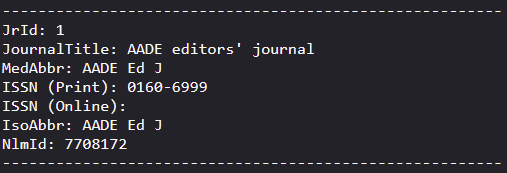

Now carry out matching between the data sets and save a final combined matching df

In [4]:
import pandas as pd
import requests
import re

# Load the filtered DataFrame and lowercase the 'Title' column
filtered_df = pd.read_csv("input/1_scimago_jr_subject_category.csv")
filtered_df['Title'] = filtered_df['Title'].str.lower()

# Fetch and parse the text file containing PubMed journals from the provided link
url = "https://ftp.ncbi.nih.gov/pubmed/J_Medline.txt"
response = requests.get(url)
if response.status_code == 200:
    text = response.text
else:
    print("Failed to fetch data from the provided URL.")
    text = None

# Function to check for direct matches and extract information
def check_direct_matches_and_extract(chunk, scimago_titles, scimago_df):
    jr_id_match = re.search(r"JrId: (\d+)", chunk)
    if jr_id_match:
        jr_id = jr_id_match.group(1)
    else:
        return []

    title_match = re.search(r"JournalTitle: (.+)", chunk)
    if title_match:
        journal_title = title_match.group(1)
    else:
        return []

    issn_print_match = re.search(r"ISSN \(Print\): (\d{4}-\d{3}[\dxX])", chunk)
    issn_print = issn_print_match.group(1) if issn_print_match else None

    # Remove dashes for matching purposes
    issn_print_clean = issn_print.replace("-", "") if issn_print else None

    # Direct matching based on journal titles and ISSN
    matched_data = []
    for scimago_title in scimago_titles:
        if journal_title.lower() == scimago_title.lower():
            # Find the matching row in the Scimago DataFrame
            matching_row = scimago_df[scimago_df['Title'] == scimago_title].iloc[0]
            scimago_issns = [issn.replace("-", "") for issn in matching_row['Issn'].split(', ')]
            matched_ISSN = issn_print_clean in scimago_issns
            matched_data.append({
                'JrId_pubmed': jr_id,
                'JournalTitle_pubmed': journal_title,
                'ISSN_Print_pubmed': issn_print,
                'Sourceid_SM': matching_row['Sourceid'],
                'Title_SM': scimago_title,
                'ISSN_SM': matching_row['Issn'],
                'Type_SM': matching_row['Type'],
                'Subject_Category_SM': matching_row['Subject_Category'],
                'Matched_ISSN': matched_ISSN
            })
    return matched_data

# Get a list of journal titles from the filtered DataFrame
scimago_titles = filtered_df['Title'].tolist()

# Check for direct matches and extract information
if text:
    matched_data = []
    for chunk in text.split("--------------------------------------------------------"):
        matched_data.extend(check_direct_matches_and_extract(chunk, scimago_titles, filtered_df))

    # Create DataFrame from matched data
    matched_df_direct = pd.DataFrame(matched_data)

    # Remove duplicates by keeping only the first occurrence
    matched_df_no_duplicates = matched_df_direct.drop_duplicates(subset=['JrId_pubmed'], keep='first')

    # Print rows where ISSN_Print_pubmed and ISSN_SM do not match
    unmatched_issn_rows = matched_df_no_duplicates[
        ~matched_df_no_duplicates['Matched_ISSN'] & matched_df_no_duplicates['ISSN_Print_pubmed'].notnull()
    ]

    print("\nRows where ISSN_Print_pubmed and ISSN_SM do not match:")
    print(unmatched_issn_rows)

    # Print the total number of rows where ISSN do not match
    print(f"\nTotal number of rows where ISSN do not match: {len(unmatched_issn_rows)}")

    # Save rows without duplicates to CSV file
    no_duplicates_csv_file_path = "input/2_pubmed_SM_matched_journals.csv"
    matched_df_no_duplicates.to_csv(no_duplicates_csv_file_path, index=False)
    print(f"Rows (including mismatching ISSN rows) saved to {no_duplicates_csv_file_path}")

    # Find and save duplicates
    duplicates = matched_df_direct[matched_df_direct.duplicated(subset=['JrId_pubmed'], keep=False)]
    if not duplicates.empty:
        duplicates_csv_file_path = "input/duplicates.csv"
        duplicates.to_csv(duplicates_csv_file_path, index=False)
        print(f"Duplicates saved to {duplicates_csv_file_path}")
    else:
        print("No duplicates found.")

else:
    print("No data fetched from the URL.")


Rows where ISSN_Print_pubmed and ISSN_SM do not match:
    JrId_pubmed                                JournalTitle_pubmed  \
127        7390                                  Social psychology   
133        8145  Zeitschrift fur klinische Psychologie und Psyc...   
193       25292                                           Dialogue   
276       27812                           Merrill-Palmer quarterly   
377       34115              European journal of behavior analysis   
705       46950         Comprehensive results in social psychology   
735       48196  Research and practice in technology enhanced l...   
736       48231                      Journal of language evolution   
755       49055              Journal of cultural cognitive science   
756       49240                      International journal of play   
763       49625        Journal of behavioral and cognitive therapy   
781       50302  Journal of the Academy of Consultation-Liaison...   

    ISSN_Print_pubmed  Sourceid_S

Descriptives by subject category

In [5]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("input/2_pubmed_SM_matched_journals.csv")

# Group the DataFrame by 'Subject_Category_SM' and count the number of rows in each group
category_counts = df.groupby('Subject_Category_SM').size()

# Sort the counts in descending order
category_counts_sorted = category_counts.sort_values(ascending=False)

# Print the total number of rows in the DataFrame
print("Total number of rows in the DataFrame:", len(df))

# Print the number of rows grouped by subject category, sorted from largest to smallest counts
print("\nNumber of rows grouped by subject category (sorted by counts in descending order):")
print(category_counts_sorted)


Total number of rows in the DataFrame: 623

Number of rows grouped by subject category (sorted by counts in descending order):
Subject_Category_SM
Developmental_and_Educational_Psychology        148
Social_Psychology                               138
Clinical_Psychology                             116
Psychology_(miscellaneous)                      105
Applied_Psychology                               59
Experimental_and_Cognitive_Psychology            38
Neuropsychology_and_Physiological_Psychology     19
dtype: int64
